### Steps
- try with month end prices to more closely tie out to portfolio visualizer.
- random/grid search; space points rather then completely random vectors.

In [48]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import pytz
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [49]:
# Define params
symbols = ['TLT', 'GLD', 'XLP', 'XLV', 'XLK']
start_date = datetime(2020, 1, 1, tzinfo=pytz.utc)
end_date = datetime(2024, 1, 1, tzinfo=pytz.utc)
num_tests = 5000

vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.portfolio['seed'] = 42
vbt.settings.portfolio.stats['incl_unrealized'] = True

In [50]:
yfdata = vbt.YFData.download(symbols, start=start_date, end=end_date)
print(yfdata.symbols)


['TLT', 'GLD', 'XLP', 'XLV', 'XLK']


In [51]:
ohlcv = yfdata.concat()
print(ohlcv.keys())

dict_keys(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains'])


In [52]:
price = ohlcv['Close']
print(price.head(5))

symbol                            TLT         GLD        XLP        XLV  \
Date                                                                      
2020-01-02 05:00:00+00:00  123.894501  143.949997  55.870934  95.468811   
2020-01-03 05:00:00+00:00  125.802605  145.860001  55.781525  94.636871   
2020-01-06 05:00:00+00:00  125.088226  147.389999  55.897766  95.225784   
2020-01-07 05:00:00+00:00  124.473312  147.970001  55.468536  95.038818   
2020-01-08 05:00:00+00:00  123.650398  146.860001  55.674210  95.655762   

symbol                           XLK  
Date                                  
2020-01-02 05:00:00+00:00  89.715004  
2020-01-03 05:00:00+00:00  88.706306  
2020-01-06 05:00:00+00:00  88.917664  
2020-01-07 05:00:00+00:00  88.879227  
2020-01-08 05:00:00+00:00  89.830261  


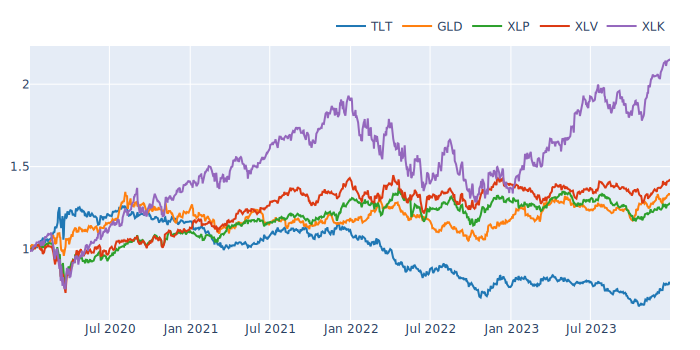

In [53]:
# Plot normalized price series
(price / price.iloc[0]).vbt.plot().show_svg()

In [54]:
returns = price.pct_change()

In [55]:
print(returns.mean())

symbol
TLT   -0.000168
GLD    0.000331
XLP    0.000312
XLV    0.000429
XLK    0.000928
dtype: float64


In [56]:
print(returns.std())

symbol
TLT    0.011841
GLD    0.009859
XLP    0.011517
XLV    0.012453
XLK    0.018414
dtype: float64


In [57]:
print(returns.corr())

symbol       TLT       GLD       XLP       XLV       XLK
symbol                                                  
TLT     1.000000  0.277931 -0.170400 -0.171483 -0.127046
GLD     0.277931  1.000000  0.161449  0.131410  0.147060
XLP    -0.170400  0.161449  1.000000  0.799644  0.670766
XLV    -0.171483  0.131410  0.799644  1.000000  0.748122
XLK    -0.127046  0.147060  0.670766  0.748122  1.000000


## vectorbt: Random search

### One-time allocation

In [58]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(symbols))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))
print(weights)

5000
[array([0.13319703, 0.33810082, 0.26031769, 0.21289984, 0.05548463]), array([0.06528492, 0.02430844, 0.36250145, 0.25157131, 0.29633388]), array([0.00928442, 0.43746759, 0.37546445, 0.09577331, 0.08201023]), array([0.10567349, 0.17529743, 0.30235266, 0.24887685, 0.16779957]), array([0.32790893, 0.07475863, 0.15656842, 0.19634347, 0.24442055]), array([0.36725661, 0.09339501, 0.24052697, 0.27709479, 0.02172662]), array([0.22031348, 0.06183702, 0.0235896 , 0.34409356, 0.35016633]), array([0.34619852, 0.13045173, 0.04182837, 0.29302479, 0.18849659]), array([0.06706488, 0.27211947, 0.01889786, 0.49970785, 0.14220993]), array([0.29764696, 0.14004035, 0.23364749, 0.24561687, 0.08304833]), array([0.23212777, 0.18557416, 0.22492497, 0.21423017, 0.14314293]), array([0.58460905, 0.05611776, 0.12428307, 0.02868101, 0.20630911]), array([0.18278209, 0.12760649, 0.38972788, 0.16776931, 0.13211422]), array([0.21305135, 0.05532396, 0.31492608, 0.02926705, 0.38743156]), array([0.30904608, 0.0795244

In [59]:
# Build column hierarchy such that one weight corresponds to one price series
_price = price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='symbol_group'))
_price = _price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_price.columns)

MultiIndex([( 0.13319702814025883,    0, 'TLT'),
            ( 0.33810081711389406,    0, 'GLD'),
            ( 0.26031768763785473,    0, 'XLP'),
            (  0.2128998389048247,    0, 'XLV'),
            ( 0.05548462820316767,    0, 'XLK'),
            ( 0.06528491964469331,    1, 'TLT'),
            ( 0.02430844330237927,    1, 'GLD'),
            (  0.3625014516740258,    1, 'XLP'),
            (  0.2515713061862386,    1, 'XLV'),
            ( 0.29633387919266296,    1, 'XLK'),
            ...
            ( 0.28174358513647535, 4998, 'TLT'),
            ( 0.11280551164069287, 4998, 'GLD'),
            (  0.4806011873807442, 4998, 'XLP'),
            ( 0.09943755223425048, 4998, 'XLV'),
            (0.025412163607837292, 4998, 'XLK'),
            (  0.0918140260728043, 4999, 'TLT'),
            ( 0.20381176992048122, 4999, 'GLD'),
            (  0.2588484695270744, 4999, 'XLP'),
            ( 0.17866895298772756, 4999, 'XLV'),
            ( 0.26685678149191244, 4999, 'XLK')],
   

In [60]:
# Define order size
size = np.full_like(_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(1006, 25000)


In [61]:
print(size)

[[0.13319703 0.33810082 0.26031769 ... 0.25884847 0.17866895 0.26685678]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [62]:
# Run simulation
pf = vbt.Portfolio.from_orders(
    close=_price,
    size=size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(pf.orders))

25000


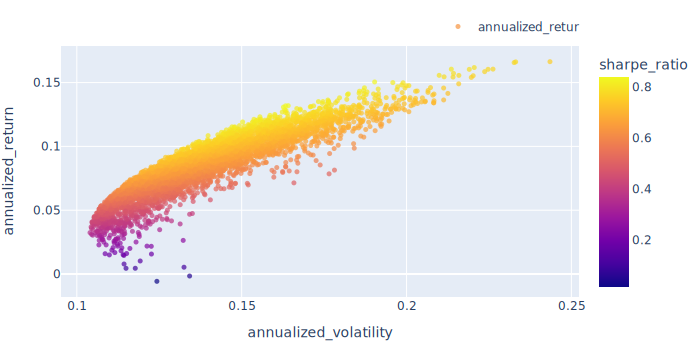

In [63]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = pf.annualized_return()
annualized_return.index = pf.annualized_volatility()
annualized_return.vbt.scatterplot(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=pf.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_svg()

In [64]:
# Get index of the best group according to the target metric
best_symbol_group = pf.sharpe_ratio().idxmax()

print(best_symbol_group)

1764


In [65]:
# Print best weights
print(weights[best_symbol_group])

[0.03892524 0.46075364 0.05902452 0.0335764  0.4077202 ]


In [66]:
# Compute default stats
print(pf.iloc[best_symbol_group].stats())

Start                         2020-01-02 05:00:00+00:00
End                           2023-12-29 05:00:00+00:00
Period                               1006 days 00:00:00
Start Value                                       100.0
End Value                                    163.919257
Total Return [%]                              63.919257
Benchmark Return [%]                          39.216304
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              22.872418
Max Drawdown Duration                 365 days 00:00:00
Total Trades                                          5
Total Closed Trades                                   0
Total Open Trades                                     5
Open Trade PnL                                63.919257
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

### Rebalance monthly

In [67]:
# Select the first index of each month
rb_mask = ~_price.index.to_period('Q').duplicated()

print(rb_mask.sum())

16


/tmp/ipykernel_2494405/44684932.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [68]:
rb_size = np.full_like(_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(1006, 25000)


In [69]:
print(rb_size)

[[0.13319703 0.33810082 0.26031769 ... 0.25884847 0.17866895 0.26685678]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [70]:
# Run simulation, with rebalancing monthly
rb_pf = vbt.Portfolio.from_orders(
    close=_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='symbol_group',
    cash_sharing=True,
    call_seq='auto'  # important: sell before buy
)

print(len(rb_pf.orders))

399998


In [71]:
rb_best_symbol_group = rb_pf.sharpe_ratio().idxmax()

print(rb_best_symbol_group)

1920


In [72]:
print(weights[rb_best_symbol_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [73]:
print(rb_pf.iloc[rb_best_symbol_group].stats())

Start                         2020-01-02 05:00:00+00:00
End                           2023-12-29 05:00:00+00:00
Period                               1006 days 00:00:00
Start Value                                       100.0
End Value                                    164.224424
Total Return [%]                              64.224424
Benchmark Return [%]                          39.216304
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              19.706487
Max Drawdown Duration                 340 days 00:00:00
Total Trades                                         38
Total Closed Trades                                  33
Total Open Trades                                     5
Open Trade PnL                                 50.88569
Win Rate [%]                                      100.0
Best Trade [%]                                95.775307
Worst Trade [%]                                2

In [74]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=symbols,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show_svg()

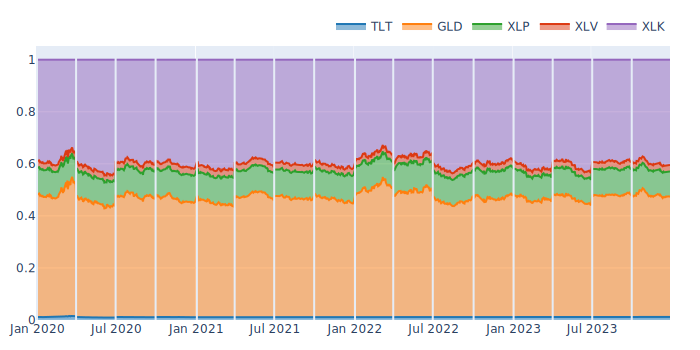

In [75]:
plot_allocation(rb_pf.iloc[rb_best_symbol_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [76]:
srb_sharpe = np.full(price.shape[0], np.nan)

@njit
def pre_sim_func_nb(c, every_nth):
    # Define rebalancing days
    c.segment_mask[:, :] = False
    c.segment_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(c, price, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (price[1:] - price[:-1]) / price[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    weights = np.full(c.group_len, np.nan, dtype=np.float_)
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(c.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def pre_segment_func_nb(c, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, close, num_tests)
    srb_sharpe[c.i] = best_sharpe_ratio

    # Update valuation price and reorder orders
    size_type = SizeType.TargetPercent
    direction = Direction.LongOnly
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

    return (weights,)

@njit
def order_func_nb(c, weights):
    col_i = c.call_seq_now[c.call_idx]
    return order_nb(
        weights[col_i], 
        c.close[c.i, c.col],
        size_type=SizeType.TargetPercent
    )

In [77]:
ann_factor = returns.vbt.returns.ann_factor

In [78]:
# Run simulation using a custom order function
srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True
)

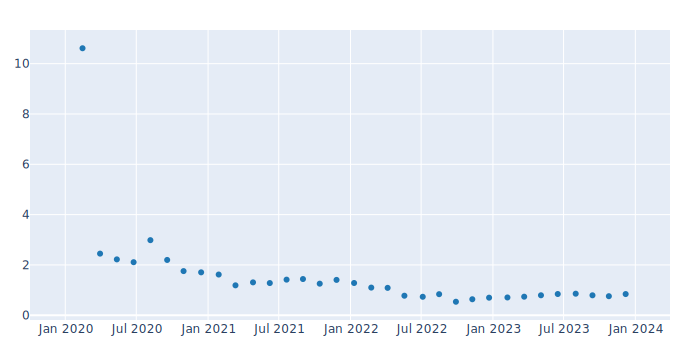

In [79]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [80]:
print(srb_pf.stats())

Start                           2020-01-02 05:00:00+00:00
End                             2023-12-29 05:00:00+00:00
Period                                 1006 days 00:00:00
Start Value                                         100.0
End Value                                      112.345312
Total Return [%]                                12.345312
Benchmark Return [%]                            39.216304
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                27.844192
Max Drawdown Duration                   505 days 00:00:00
Total Trades                                           83
Total Closed Trades                                    78
Total Open Trades                                       5
Open Trade PnL                                   15.51394
Win Rate [%]                                    58.974359
Best Trade [%]                                  33.109708
Worst Trade [%

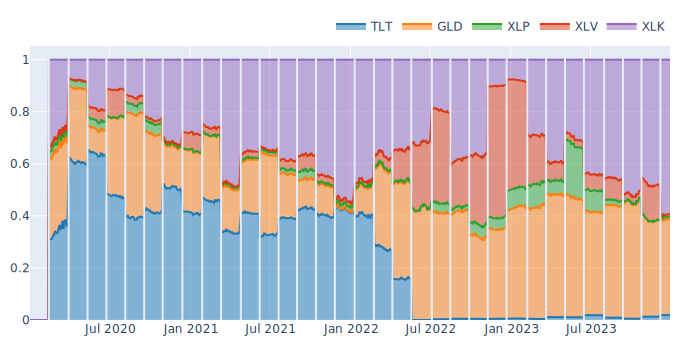

In [81]:
plot_allocation(srb_pf)

You can see how weights stabilize themselves with growing data.

In [82]:
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(price.shape[0], np.nan)

srb252_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb,
    pre_segment_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True
)

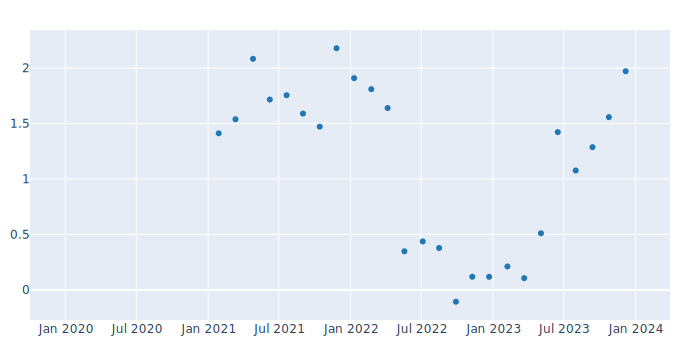

In [83]:
pd.Series(srb252_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [84]:
print(srb252_pf.stats())

Start                         2020-01-02 05:00:00+00:00
End                           2023-12-29 05:00:00+00:00
Period                               1006 days 00:00:00
Start Value                                       100.0
End Value                                    119.337346
Total Return [%]                              19.337346
Benchmark Return [%]                          39.216304
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              19.023189
Max Drawdown Duration                 475 days 00:00:00
Total Trades                                         62
Total Closed Trades                                  57
Total Open Trades                                     5
Open Trade PnL                                11.910308
Win Rate [%]                                  52.631579
Best Trade [%]                                16.730536
Worst Trade [%]                              -16

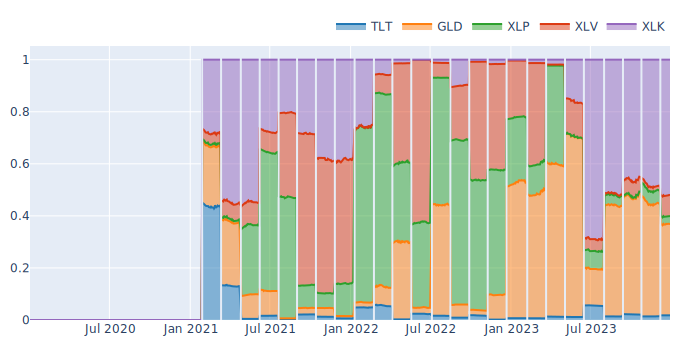

In [85]:
plot_allocation(srb252_pf)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [86]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(price)
cov_mat = risk_models.sample_cov(price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[symbol] for symbol in symbols])

print(pyopt_weights)

[0.      0.43469 0.      0.      0.56531]


In [87]:
pyopt_size = np.full_like(price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(1006, 5)


In [88]:
# Run simulation with weights from PyPortfolioOpt
pyopt_pf = vbt.Portfolio.from_orders(
    close=price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True
)

print(len(pyopt_pf.orders))

2


Faster than stacking solution, but doesn't let you compare weights.

In [89]:
print(pyopt_pf.stats())

Start                         2020-01-02 05:00:00+00:00
End                           2023-12-29 05:00:00+00:00
Period                               1006 days 00:00:00
Start Value                                       100.0
End Value                                    178.813238
Total Return [%]                              78.813238
Benchmark Return [%]                          39.216304
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              25.843535
Max Drawdown Duration                 365 days 00:00:00
Total Trades                                          2
Total Closed Trades                                   0
Total Open Trades                                     2
Open Trade PnL                                78.813238
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

### Search and rebalance monthly

You can't use third-party optimization packages within Numba (yet).

Here you have two choices:
1) Use `os.environ['NUMBA_DISABLE_JIT'] = '1'` before all imports to disable Numba completely
2) Disable Numba for the function, but also for every other function in the stack that calls it

We will demonstrate the second option.

In [90]:
def pyopt_find_weights(sc, price, num_tests):  # no @njit decorator = it's a pure Python function
    # Calculate expected returns and sample covariance matrix
    price = pd.DataFrame(price, columns=symbols)
    avg_returns = expected_returns.mean_historical_return(price)
    cov_mat = risk_models.sample_cov(price)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[symbol] for symbol in symbols])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [91]:
pyopt_srb_sharpe = np.full(price.shape[0], np.nan)

# Run simulation with a custom order function
pyopt_srb_pf = vbt.Portfolio.from_order_func(
    price,
    order_func_nb,
    pre_sim_func_nb=pre_sim_func_nb,
    pre_sim_args=(30,),
    pre_segment_func_nb=pre_segment_func_nb.py_func,  # run pre_segment_func_nb as pure Python function
    pre_segment_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    use_numba=False  # run simulate_nb as pure Python function
)

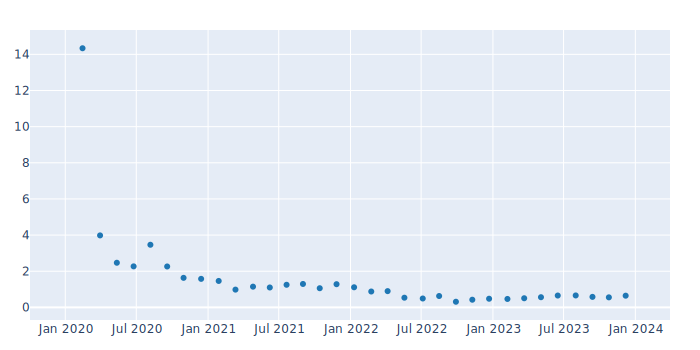

In [92]:
pd.Series(pyopt_srb_sharpe, index=price.index).vbt.scatterplot(trace_kwargs=dict(mode='markers')).show_svg()

In [93]:
print(pyopt_srb_pf.stats())

Start                           2020-01-02 05:00:00+00:00
End                             2023-12-29 05:00:00+00:00
Period                                 1006 days 00:00:00
Start Value                                         100.0
End Value                                       99.412099
Total Return [%]                                -0.587901
Benchmark Return [%]                            39.216304
Max Gross Exposure [%]                              100.0
Total Fees Paid                                       0.0
Max Drawdown [%]                                33.528463
Max Drawdown Duration                   505 days 00:00:00
Total Trades                                           50
Total Closed Trades                                    48
Total Open Trades                                       2
Open Trade PnL                                  15.033505
Win Rate [%]                                    45.833333
Best Trade [%]                                  30.766566
Worst Trade [%

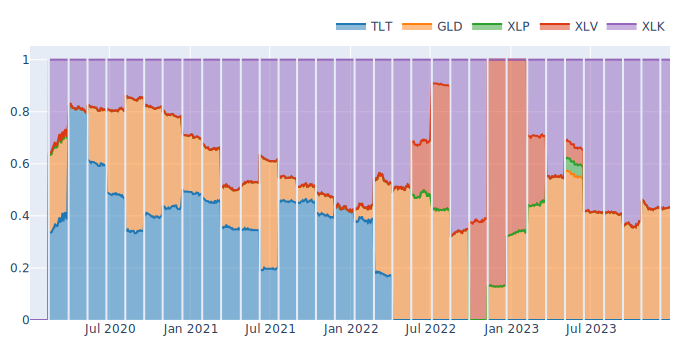

In [94]:
plot_allocation(pyopt_srb_pf)